# COMP 755

Plan for today

1. Unsupervised learning
2. Mixture models
3. EM algorithm
    

$$
\renewcommand{\xx}{\mathbf{x}}
\renewcommand{\yy}{\mathbf{y}}
\renewcommand{\zz}{\mathbf{z}}
\renewcommand{\vv}{\mathbf{v}}
\renewcommand{\bbeta}{\boldsymbol{\mathbf{\beta}}}
\renewcommand{\mmu}{\boldsymbol{\mathbf{\mu}}}
\renewcommand{\ssigma}{\boldsymbol{\mathbf{\sigma}}}
\renewcommand{\reals}{\mathbb{R}}
\renewcommand{\loglik}{\mathcal{LL}}
\renewcommand{\penloglik}{\mathcal{PLL}}
\renewcommand{\likelihood}{\mathcal{L}}
\renewcommand{\Data}{\textrm{Data}}
\renewcommand{\given}{ \big| }
\renewcommand{\MLE}{\textrm{MLE}}
\renewcommand{\EE}{\mathbb{E}}
\renewcommand{\KL}{\textrm{KL}}
\renewcommand{\Bound}{\mathcal{B}}
\renewcommand{\tth}{\textrm{th}}
\renewcommand{\Gaussian}[2]{\mathcal{N}\left(#1,#2\right)}
\renewcommand{\norm}[1]{\left\lVert#1\right\rVert}
\renewcommand{\ones}{\mathbf{1}}
\renewcommand{\diag}[1]{\textrm{diag}\left( #1 \right)}
\renewcommand{\sigmoid}[1]{\sigma\left(#1\right)}
\renewcommand{\myexp}[1]{\exp\left\{#1\right\}}
\renewcommand{\mylog}[1]{\log\left\{#1\right\}}
\renewcommand{\argmax}{\mathop{\textrm{argmax}}}
\renewcommand{\new}{\textrm{new}}
\renewcommand{\old}{\textrm{old}}
$$

# Unsupervised learning

In supervised learning, data is given in form
$$
\Data = \{(\xx_t,\yy_t) \mid t=1,...T\}
$$
There is a feature/predictor vector $\xx$ and a target variable $\yy$.

In unsupervised learning this distinction disappeares
$$
\Data = \{\xx_t \mid t=1,...T\}
$$



# Examples of unsupervised learning

* Dimensionality reduction -- lossy compression 
* Clustering -- assigning each point to a representative cluster
  * Note: in classification groups are known, in clustering they are learned
* Deconvolution -- splitting mixed signals such as instruments or speakers in sound signal

Applications
* Data summarization/compression
* Denoising, outlier detection
* Feature construction

# Clustering

We will first look at a very simple -- and popular -- clustering algorithm called *K-means*

The algorithm iterates
1. assignment of samples to the closest of the **K** clusters
2. updates to clusters' **means**




Text(0.5,1,'Data')

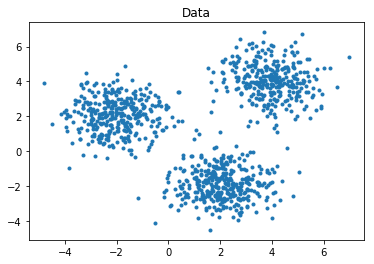

In [1]:
import numpy
import matplotlib.pyplot as plt
%matplotlib inline
def generate_data(N,d,K,proby,mus,A=None):    
    if A is None:
        A = numpy.eye(d)
    ys = [0]*N
    xs = numpy.zeros((d,N))
    for i in range(N):
        # Sample class according to the prior p(y)
        # in this case it is uniform
        ys[i] = numpy.random.choice(K,1)      
        # Sample feature values according to p(x|y)
        # In this case, x ~ N(mmu[y[i]],sigma2*I)
        # To accomplish this, draw z1,z2 ~ N(0,I)    
        z = numpy.random.randn(2,1)
        # transform by matrix A and shift by class mean
        x = numpy.dot(A,z) + mus[:,ys[i]]  
        xs[:,i] = x[:,0]
    return xs,ys

def plot_samples(xs,ys,mus=None,colors=['r','g','b','k','c','m']):
    if not ys is None:        
        K = numpy.max(ys)+1        
        for c in range(K):
        # indices of samples assigned to class c
            ind = [i for i in range(N) if ys[i]==c]
            plt.plot(xs[0,ind],xs[1,ind],colors[c]+'.',label='Samples in cluster '+str(c))    
            if not mus is None:
                plt.plot(mus[0,c],mus[1,c],'kx',markersize=9,markeredgewidth=5)
                plt.plot(mus[0,c],mus[1,c],'wx',markersize=7,markeredgewidth=3)
        plt.legend(loc=2, bbox_to_anchor=(1,1))
    else:
        plt.plot(xs[0,:],xs[1,:],'.')
            

def plot_samples_post(xs,qs,mus=None,colors=['r','g','b','k','c','m']):
    K,N = qs.shape
    for i in range(N):
        plt.plot(xs[0,i],xs[1,i],'o',color=qs[:,i])
    for c in range(K):
    # indices of samples assigned to class c
        if not mus is None:
            plt.plot(mus[0,c],mus[1,c],'kx',markersize=9,markeredgewidth=5)
            plt.plot(mus[0,c],mus[1,c],'wx',markersize=7,markeredgewidth=3)

            

N = 1000 # 100 samples
K = 3   # 3 classes
d = 2   # x is 2d 
proby = [1.0/K]*K # [1./3. , 1./3., 1./3.]
mus = 2.0*numpy.asarray([[-1.0,1.0,2],[1.0,-1.0,2.0]])

numpy.random.seed(1)
xs,ys = generate_data(N,d,K,proby,mus)
plot_samples(xs,None,mus)
plt.title('Data')



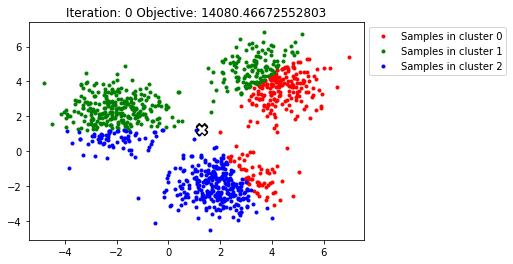

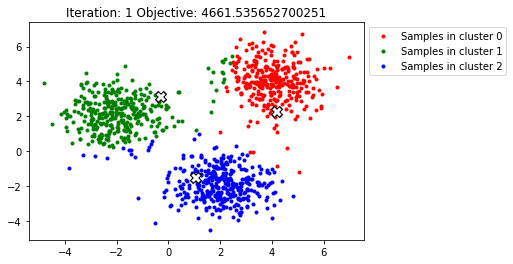

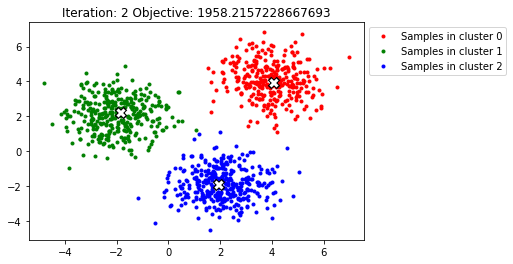

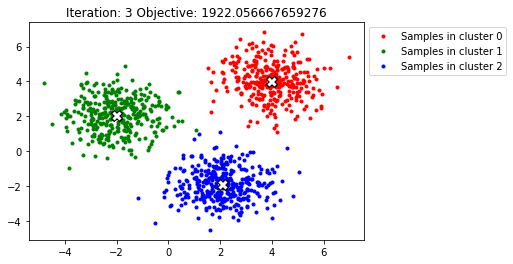

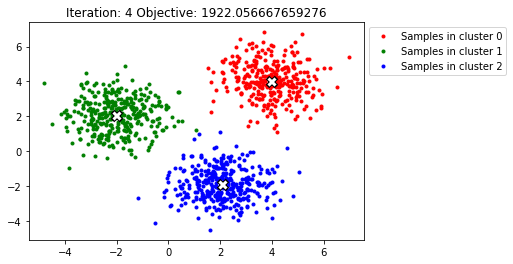

In [2]:
def kmeans(xs,K,iterations,tolerance=1e-7, just_last=False):
    # dimensions of data
    d,N = xs.shape
    
    # random initialization of centers
    data_mean = numpy.mean(xs,axis=1)[:,numpy.newaxis]
    mus = 0.01*numpy.random.randn(d,K) + data_mean
    
    # cluster assignments using 1-hot representation
    ph = numpy.zeros((K,N))
    # distance from each cluster center to each point
    last_objective = numpy.finfo('d').max
    for it in range(iterations):
        # compute distance between samples and cluster centers (mus)
        # recognize this as vectorized form of
        # x'x - 2.0 x'mu 
        mus_sq = numpy.asmatrix(numpy.sum(mus**2.0,axis=0)).transpose()
        mus_xs = numpy.dot(mus.transpose(),xs)
        xs_sq = numpy.sum(xs**2.0,axis=0)
        distance =  mus_sq  - 2.0*mus_xs + xs_sq
        
        # objective is sum of distances from each sample
        # to its closest cluster
        objective = numpy.sum(numpy.min(distance,axis=0))
        
        # find closest clusters all at once
        h = numpy.argmin(distance,axis=0).transpose()        
        
        # convert the closest cluster id to one-hot
        # representation
        ph[:] = 0
        for (i,v) in enumerate(h):
            ph[v,i] = 1.0
         
        # visualization
        if not just_last:
            plt.figure()
            plot_samples(xs,h,mus)
            plt.title('Iteration: {} Objective: {}'.format(it,objective))
            
        # check whether sufficient change has occurred
        if last_objective - objective < tolerance:
            break
        else:           
            last_objective = objective       
           
        # update each cluster center with mean of samples in that cluster
        # make sure not to divide by 0 -- in case of an empty cluster
        mus = numpy.dot(xs,ph.transpose())/(1e-5 + numpy.sum(ph,axis=1))
    
    if just_last:
        plt.figure()
        plot_samples(xs,h,mus)
        plt.title('Final after {} iterations with objective {}'.format(it,objective))
    return h,mus


numpy.random.seed(1)
xs,ys = generate_data(N,d,K,proby,mus)
numpy.random.seed(1)
kmeans(xs,K=3,iterations=100,tolerance=1e-3); 


Text(0.5,1,'Poor initialization')

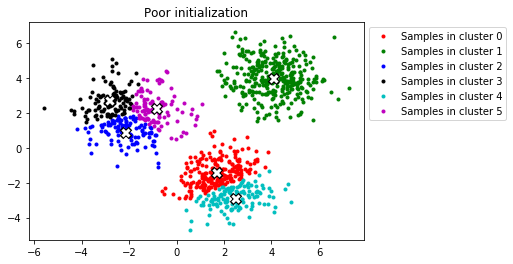

In [3]:
N = 1000 # 100 samples
K = 3   # 3 classes
d = 2   # x is 2d 
proby = [1.0/K]*K # [1./3. , 1./3., 1./3.]
mus = 2.0*numpy.asarray([[-1.0,1.0,2],[1.0,-1.0,2.0]])

numpy.random.seed(6)
xs,ys = generate_data(N,d,K,proby,mus=mus)
kmeans(xs,K=6,iterations=30,tolerance=1e-7,just_last = True);
plt.title('Poor initialization')

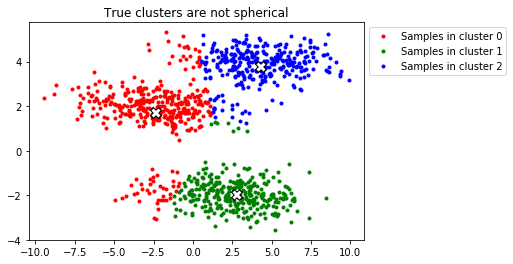

In [4]:
numpy.random.seed(7)
A = 1.4*numpy.random.randn(2,2)
xs,ys = generate_data(N,d,K,proby,mus,A)
kmeans(xs,K=3,iterations=10,tolerance=1e-3,just_last = True);
plt.title('True clusters are not spherical');

# K-means observations

1. Initialization is random -- means of the clusters are slightly preturbed versions of data mean.
2. Clusters are assumed to be spherical
3. Clusters can have zero members -- make sure there is no division with zero 
```
mus = numpy.dot(xs,ph.transpose())/(1e-5 + numpy.sum(ph,axis=1))
```
4. There are local minima
   * Trivial: renaming of clusters
   * Non-trivial: poor initialization, too small or too large K
5. Multiple restarts -- from different initializations -- can lead to better solutions


# How do we come up with an algorithm such as K-means?

We will:
1. Write out a generative model for the data
2. Write out log-likelihood
3. Optimize log-likelihood

The twist compared to our previous model learning is in the fact that not all the variables are observed.

Labels, indicating cluster membership, are **hidden** from us.



# Mixture models

Mixture models are suited to the data exhibit clusters. 

Each cluster is called **mixture component**


Data is given to us as $\Data = \{\xx_t \mid t=1,...T\}$

We introduce a random variable $h$ that tells us which cluster or mixture component the sample came from.




# Mixture models -- generative story

Each sample $\xx$ is generated by:
1. Selecting a cluster, according to some distribution $\pi = (\pi_1,...,\pi_K)$
$$
p(h) = \pi_h
$$
2. Using parameters of cluster $h$ generate the sample $\xx$
$$
p(\xx \mid h,\theta) = p(\xx \mid \theta_h)
$$

For example, you can think of $\theta_h$ as the mean of the cluster $h$
$$
p(\xx \mid \theta_h) = \prod_{i=1}^d \frac{1}{\sqrt{2\pi\sigma^2}} \myexp{-\frac{1}{2\sigma^2}(x_i - \theta_{h,i})^2}
$$



Text(0.5,1,'$h$ indicates cluster membership,\n$\\theta$ are cluster centers')

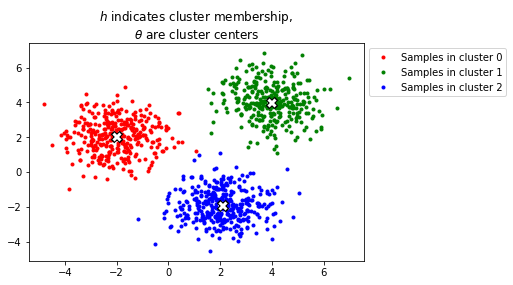

In [5]:
numpy.random.seed(1)
xs,ys = generate_data(N,d,K,proby,mus)
kmeans(xs,K=3,iterations=100,tolerance=1e-3,just_last=True); 
plt.title("$h$ indicates cluster membership,\n$\\theta$ are cluster centers")

# Mixture models -- generative story

Note that generative model talks about how data might have been generated.

We want to fit a model under which that data is most probable.

To do so, we must write out log-likelihood 
$$
\loglik(\Theta) = \sum_t \log p(\xx_t \mid\Theta)
$$
and maximize it with respect to parameters $\Theta$.


# Marginal Log-likelihood 

For a single sample $\xx$, we know how to compute $p(h)$ and $p(\xx\mid h,\Theta)$ so we can obtain joint 
$$
p(\xx,h \mid \Theta) = p(h) p(\xx\mid h,\Theta).
$$
This is probability of the full configuration $\xx$ **and** cluster membership $h$.

Our data does not contain information about cluster membership, just vectors $\xx$.

How do we compute $p(\xx \mid \Theta)$?

# Marginal Log-likelihood 

We can use the fact that
$$
p(\xx\mid\Theta) = \sum_h p(\xx,h \mid \Theta)  = \sum_h p(h)p(\xx\mid h,\Theta).
$$

What is the interpretation of this sum?

# Marginal Log-likelihood
Now, we can express log-likelihood in terms of probabilities in our model
$$
\loglik(\Theta) = \sum_t \log p(\xx_t\mid\Theta) = \sum_{t=1}^T \log  \sum_{h_t} p(\xx_t,h_t\mid \Theta).
$$

Observations
1. For each sample $\xx_t$, we have corresponding cluster membership variable $h_t$
2. There is a sum under the log so we cannot push the log to probability terms

# Dealing with difficult objectives

Typically, when we run into an objective that is difficult to work with (for example log of sums above), we seek a closely related objective that is easier.

Hence, we will not directly optimize the log-likelihood instead we will introduce a lower-bound on the log-likelihood which we will show is tight at the optimum.

To accomplish this we a bit of math that you may not be familar with
1. Convex and concave functions
2. Jensen's inequality

# Concave functions 

A function $f(x)$ is concave if
$$
f(\lambda x + (1-\lambda)y) \geq \lambda f(x)  + (1-\lambda)f(y)
$$
for any $\lambda \in [0,1]$
Examples of concave functions are log, exp, square, etc.

Text(0.5,1,'NegLog is convex')

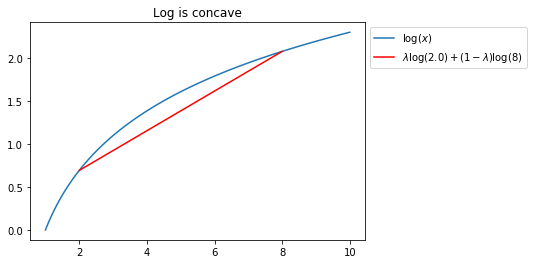

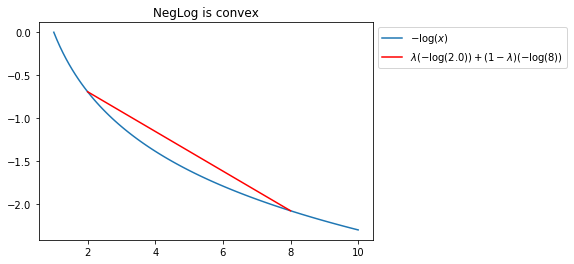

In [6]:
x = numpy.linspace(1.,10.0,100)
px = [2.0,8.0]

plt.plot(x,numpy.log(x),label ='$\log(x)$')
plt.plot(px,numpy.log(px),'r',label = '$\lambda \log(2.0) + (1-\lambda) \log(8)$')
plt.legend(loc=2, bbox_to_anchor=(1,1))
plt.title('Log is concave')
plt.figure()
plt.plot(x,-numpy.log(x),label ='$-\log(x)$')
plt.plot(px,-numpy.log(px),'r',label = '$\lambda (-\log(2.0)) + (1-\lambda) (-\log(8))$')
plt.legend(loc=2, bbox_to_anchor=(1,1))
plt.title('NegLog is convex')


# Jensen's inequality
Jensen's inequality 
$$
f(\EE[H]) \geq \EE[f(H)]
$$
where
$$
\EE[H] = \sum_h p(H=h)h.
$$ 
and $f$ is concave.

# Bounding log-likelihood

Starting with log-likelihood
$$
\loglik(\Theta) = \sum_t \log p(\xx_t\mid\Theta) = \sum_{t=1}^T \log  \sum_{h_t} p(\xx_t,h_t\mid \Theta).
$$
we introduce distributions $q_t(h_t)$ and multiply and divide by them
$$
\begin{aligned}
\loglik(\Theta) &= \sum_t \log p(\xx_t\mid\Theta) = \sum_{t=1}^T \log  \sum_{h_t} \color{red}{\frac{q_t(h_t)}{q_t(h_t)}} p(\xx_t,h_t\mid \Theta)\\
&= \sum_{t=1}^T \log  \sum_{h_t} q_t(h_t) \frac{ p(\xx_t,h_t\mid \Theta) }{ q_t(h_t) } \\
&= \sum_{t=1}^T \log \EE_{q_t}\left[\frac{ p(\xx_t,h_t\mid \Theta) }{ q_t(h_t) }\right] \\
&\geq \sum_{t=1}^T \EE_{q_t}\left[\log \frac{ p(\xx_t,h_t\mid \Theta) }{ q_t(h_t) }\right] \\
&= \sum_{t=1}^T \sum_{h_t} q_t(h_t) \log \frac{ p(\xx_t,h_t\mid \Theta) }{ q_t(h_t) } 
\end{aligned}
$$




# Bounding log-likelihood

Starting with log-likelihood
$$
\loglik(\Theta) = \sum_t \log p(\xx_t\mid\Theta) \geq  \sum_{t=1}^T \sum_{h_t} q_t(h_t) \log \frac{ p(\xx_t,h_t\mid \Theta) }{ q_t(h_t) }  = \mathcal{B}(\Theta,q)
$$

Natural questions that arise:
1. Where do we get $q_t$s? 
2. Does optimizing bound result in the same $\Theta$?
$$
\argmax_{\Theta}\loglik(\Theta)\stackrel{?}{=}\argmax_{\Theta}\mathcal{B}(\Theta,q) 
$$


# Bounding log-likelihood

Before we start answering the questions we note that 
$$
\loglik(\Theta) \geq \mathcal{B}(\Theta,q)
$$
no matter which $q_t$s we choose so we can seek maximum of $\mathcal{B}(\Theta,q)$ with respect to a particular $q_s$ and see what that gets us.

$$
\argmax_{q_s} \sum_{t=1}^T \sum_{h_t} q_t(h_t) \log \frac{ p(\xx_t,h_t\mid \Theta) }{ q_t(h_t) } = \argmax_{q_s}\underbrace{\sum_{h_s} q_s(h_s)\log \frac{ p(h_s \mid \xx_s,\Theta) }{ q_s(h_s) }}_{\KL(q(h_s||p(h_s \mid \xx_s,\Theta)} 
$$

In words, optimal $q_s$ is equal to $p(h_s \mid \xx_s,\Theta)$, posterior probability of sample $s$'s cluster membership.

# Bounding log-likelihood

Further if we use optimal $q_t$s denoted by $q^*_t$
$$
\mathcal{B}(\Theta,q^*) = \sum_{t=1}^T \sum_{h_t}p(h_t \mid \xx_s,\Theta)\log \frac{p(\xx_t,h_t\mid \Theta)}{p(h_t \mid \xx_s,\Theta)} = \sum_{t=1}^T \log  p(\xx_t \mid \Theta)  = \loglik(\Theta)
$$

Hence, if 
$$
q_t(h_t) = p(h_t \mid \xx_t,\Theta)
$$
the bound is tight.

# Bounding log-likelihood

Natural questions that arise:
*  Where do we get $q_t$s? 
 * A: We use posterior probabilities $p(h_t \mid \xx_t,\Theta)$


*  $\argmax_{\Theta} \loglik(\Theta) \stackrel{?}{=} \argmax_{\Theta} \mathcal{B}(\Theta,q)$? 
 * A: Yes, if we use exact posterior probabilities in place of $q_t$s the two objectives coincide and optimal $\Theta$s are the same.

# Expectation-Maximization (EM) algorithm

Hence we can maximize the bound $\mathcal{B}(\Theta)$ by iterating
1. (E-step) Computing the optimal 
$$
q^{\new}_t = \argmax_{q_t} \mathcal{B}(\Theta^{\old},q) 
$$
2. (M-step) Updating $\Theta$ given current $q_t(h_T)$
$$
\Theta^{\new} = \argmax_{\Theta} \mathcal{B}(\Theta,q^{\new}) 
$$


Recall for a moment the K-means algorithm. It alternated analogous two steps:
1. Assigning each sample to a cluster
2. Cluster center computation based on assignments

# Our first EM algorithm from scratch

The model
$$
\begin{aligned}
p(h) &= \alpha_h \\
p(\xx \mid h,\mu) &= (2\pi)^{-\frac{d}{2}} \myexp{-\frac{1}{2}(\xx - \mu_h)^T(\xx - \mu_h)} \\
\end{aligned}
$$
is a variant of ** Mixture of Gaussians. **

The bound 
$$
\begin{aligned}
\Bound(\Theta,q) &= \sum_{t=1}^T \sum_{h_t} q_t(h_t) \log \frac{ p(\xx_t,h_t\mid \Theta) }{ q_t(h_t) } \\
&=  \sum_{t=1}^T \sum_{h_t} q_t(h_t) \left[ \log \alpha_{h_t} -\frac{d}{2} \log (2\pi) -\frac{1}{2}(\xx - \mu_h)^T(\xx - \mu_h) \right] \\
&- \sum_{t=1}^T \sum_{h_t} q_t(h_t) \log q_t(h_t)
\end{aligned}
$$
In this case $\Theta = (\alpha_1,...,\alpha_K,\mu_1, ...,\mu_K)$


# Our first EM algorithm from scratch - E-step
The E-step
$$
\begin{aligned}
q_t(h_t = k) &= p(h_t =k \mid \xx_t, \mu)  = \frac{p(\xx_t,h_t = k \mid \mu)}{\underbrace{\sum_c p(\xx_t,h_t=c \mid \mu)}_{\textrm{same for all values of } k}}\\
 &\propto p(\xx_t,h_t = k\mid \mu)\\
        &=  \alpha_{h_t} (2\pi)^{-\frac{d}{2}} \myexp{-\frac{1}{2}(\xx - \mu_h)^T(\xx - \mu_h)}
\end{aligned}
$$ 


# E-step: Working in log-domain

If the data vectors are long, the computation of joint probabilities can yield very tiny probabilities.

Rather than working with probabilities we work with log-probabilities. Hence we store 
$$
\log q_t(h_t = k) = \log p(\xx_t,h_t = k \mid \mu) - \log \sum_c p(\xx_t,h_t=c \mid \mu)
$$
If all the probabilities are stored in log-domain, then computation of their sum requires exponentation.
$$
\log \sum_c p(\xx_t,h_t=c \mid \mu) = \log \sum_c\exp \ \underbrace{\log p(\xx_t,h_t=c \mid \mu)}_{\textrm{stored log-probability}}
$$

In [7]:
# Naive normalization
# unnormalized log probability
logp = numpy.array([-1000,-1000])
# both should be equal to log(0.5) = -0.6931
print("Incorrectly normalized probabilities:", logp - numpy.log(numpy.sum(numpy.exp(logp))))

def logsumexp(vec):  # numeric trick
    m = numpy.max(vec,axis=0)    
    return numpy.log(numpy.sum(numpy.exp(vec-m),axis=0))+m

# both should be equal to log(0.5) = -0.6931
print("Correctly normalized probabilities:", logp - logsumexp(logp))

# 2  x 3 , normalizing across the first dimension
# all should be -0.69314
logp = numpy.array([[-1000,+1000,-1000],[-1000,+1000,-1000]]) 
print("Before column normalization:")
print(logp)
print("After column normalization:")
print(logp - logsumexp(logp))

Incorrectly normalized probabilities: [ inf  inf]
Correctly normalized probabilities: [-0.69314718 -0.69314718]
Before column normalization:
[[-1000  1000 -1000]
 [-1000  1000 -1000]]
After column normalization:
[[-0.69314718 -0.69314718 -0.69314718]
 [-0.69314718 -0.69314718 -0.69314718]]


/Users/jgs/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """


# E-step: Implementation

Given a function that computes $\log p(\xx,h|\Theta)$ for all samples and all classes called ```logjointp(x,Theta)```

```python
q = numpy.zeros((K,N)) # clusters x samples
q = logjointp(x,Theta) # compute all joints at once
q = q - logsumexp(q)   # normalizing across clusters
```

# M-step: Deriving updates

In M-step we optimize $\Theta$ given $q$s
$$
\Theta^{\new} = \argmax_{\Theta} \mathcal{B}(\Theta,q^{\new}) 
$$

In general, we can take derivatives, equate them to zero, and solve:
$$
\nabla_{\Theta}  \mathcal{B}(\Theta,q^{\new})  = 0 
$$
Relevant parts of the bound are
$$
 \sum_{t=1}^T \sum_{h_t} q_t(h_t) \left[ \log \alpha_{h_t}  -\frac{1}{2}(\xx - \mu_h)^T(\xx - \mu_h) \right] 
 $$

In case of $\alpha$s we need to enforce the constraint that 
$$ 
\sum_c \alpha_c  - 1 = 0. 
$$

 



# M-step: Details of deriving $\alpha$ update

We need to solve the problem
$$
 \argmax_{\alpha,\color{red}{\sum_c \alpha_c  - 1 = 0}} \sum_{t=1}^T \sum_{h_t} q_t(h_t) \left[ \log \alpha_{h_t}  -\frac{1}{2}(\xx - \mu_h)^T(\xx - \mu_h) \right] 
 $$
This is acomplished by formulating a {\bf Lagrangian}
$$
L(\alpha,\lambda) = \sum_{t=1}^T \sum_{h_t} q_t(h_t) \left[ \log \alpha_{h_t}  -\frac{1}{2}(\xx - \mu_h)^T(\xx - \mu_h) \right] - \lambda \left(\underbrace{\color{red}{\sum_c \alpha_c - 1}}_{\textrm{constraint}}\right)).
$$
We call $\lambda$ Lagrange multiplier. It 
The optimality conditions for this problem are given by
$$
\begin{aligned}
\frac{\partial}{\partial_{\alpha_c}} L(\alpha,\lambda) &= 0 & c \in \{1,...,K\}\\
\frac{\partial}{\partial_{\lambda}} L(\alpha,\lambda) &= 0
\end{aligned}
$$
We will work this out on the board.
$$
\alpha^*_c = \frac{\sum_t q_t(h_t = c)}{N}
$$




# An aside: Interpretation of the Lagrange multiplier

Constrainted optimization problems such as
$$
\begin{array}{ll}
\mathop{\textrm{maximize}}_x &f(x) \\
\textrm{subject to} & A x = b
\end{array}
$$
are solved by constructing a Lagrangian function
$$
L(x,\lambda) = f(x) - \lambda^T (Ax - b)
$$
$\lambda$ is a vector of multipliers which are adjusted so that the optimal solution of $L(x,\lambda)$ satisfies the constraint.

We can think of Lagrange multipliers $\lambda$ as a price that you need to pay if you violate the constraint.


# M-step: Details of deriving $\mu$ update

$$
\mu_c^* =  \argmax_{\mu_c} \sum_{t=1}^T \sum_{h_t} q_t(h_t) \left[ \log \alpha_{h_t}  -\frac{1}{2}(\xx - \mu_h)^T(\xx - \mu_h) \right] 
 $$
Take a gradient of the bound
$$
\nabla_{\mu_c} \Bound(\Theta,q) = \sum_t q_t(c)(\xx_t - \mu_c)  
$$
and equate it to zero
$$
\sum_t q_t(c)(\xx_t - \mu_c)  = 0
$$
to obtain
$$
\mu_c^* = \frac{\sum_t q_t(c) \xx_t}{\sum_t q_t(c)}
$$
 
Reference: For all matrix calculus tricks http://www.ee.ic.ac.uk/hp/staff/dmb/matrix/intro.html

# M-step: implementation

For our model -- mixture of Gaussians -- M-step updates $\mu$s an $\alpha$s, given current $q$
$$
\begin{aligned}
\mu_c^* &= \frac{\sum_t q_t(c) \xx_t}{\sum_t q_t(c)} \\
\alpha^*_c &= \frac{\sum_t q_t(h_t = c)}{N}
\end{aligned}
$$

```python
mus = numpy.dot(xs,q.transpose())/(1e-5 + numpy.sum(q,axis=1))
alpha = numpy.sum(q,axis=1)/N
```
Note that `xs` is of size $d \times N$, `q` is of size $K \times N$, hence 
* `numpy.dot(xs,q.tranpose())` computes $\sum_t q_t(c) \xx_t$ 
* ` numpy.sum(q,axis=1)` computes $\sum_t q_t(c)$

Iteration: 0 Log-likelihood: -2668.2486295383233 
Iteration: 1 Log-likelihood: -2620.1354979737134 
Iteration: 2 Log-likelihood: -2065.275983307732 
Iteration: 3 Log-likelihood: -1239.1534427584647 
Iteration: 4 Log-likelihood: -1167.6253597385519 


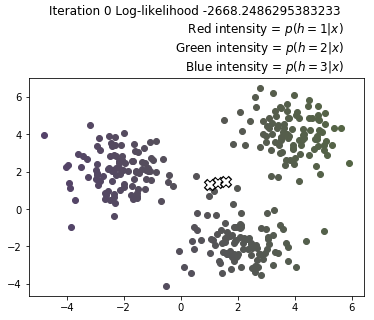

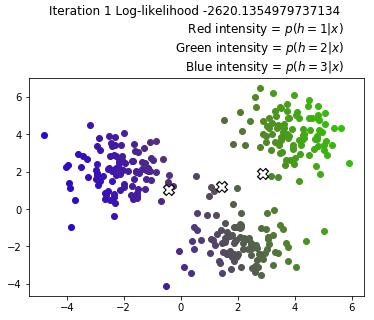

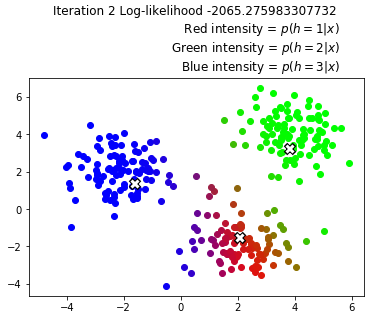

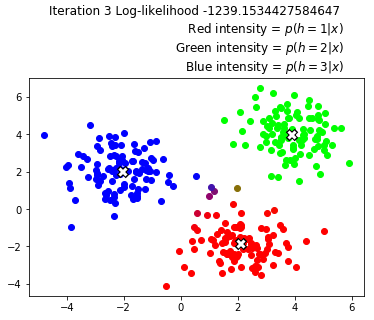

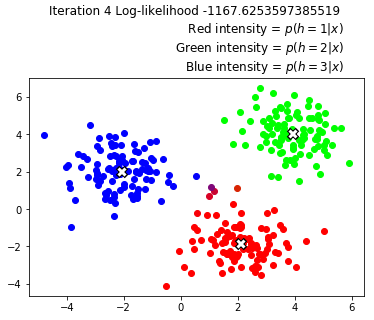

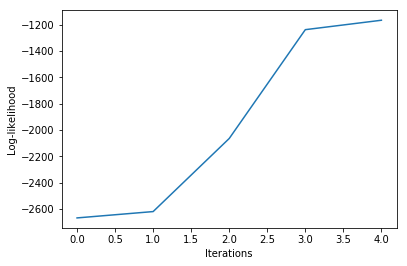

In [14]:
def mog(xs,K,iterations=10, visualize=False):
    d,N = xs.shape
    # compute mean and std of data, and convert to
    # column vectors using numpy.newaxis trick.
    data_mean = numpy.mean(xs,axis=1)[:,numpy.newaxis]
    data_std = numpy.std(xs,axis=1)[:,numpy.newaxis]
    # initialize means around the data mean but
    # ensure they are not exactly the same by adding
    # small amount of noise
    mus = data_mean + 0.01*data_std*numpy.random.randn(d,K) 
    xs_sq = numpy.sum(xs**2.0,axis=0)
        
    logalphas = numpy.array([-numpy.log(K)]*K)
    
    logconst = -(d/2.0)*numpy.log(2.0*numpy.pi)
    logliks = []
    for it in range(iterations):
        #E-step:
        mus_sq = numpy.sum(mus**2.0,axis=0)[:,numpy.newaxis]
        mus_xs = numpy.dot(mus.transpose(),xs)
        # compute log p(x,h) for all samples
        q = logalphas[:,numpy.newaxis] + logconst - 0.5*(mus_sq - 2.0*mus_xs + xs_sq)
        
        # loglikelihood is equal to sum(logsumexp(log(p(x,h))))
        loglik = numpy.sum(logsumexp(q))
        
        logliks.append(loglik)
        # normalize columns to get log(p(h|x)) for all samples
        q = numpy.exp(q - logsumexp(q))
        
        # M-step:
        
        mus = numpy.dot(xs,q.transpose())/(1e-5 + numpy.sum(q,axis=1))
        logalphas = numpy.log(numpy.sum(q,axis=1)/N)
        
        if visualize:
            print("Iteration: {} Log-likelihood: {} ".format(it,loglik))
            plt.figure()
            plot_samples_post(xs,q,mus)
            plt.title(('Iteration {} Log-likelihood {} \n '+ 
                       'Red intensity = $p(h=1|x)$\nGreen intensity = $p(h=2|x)$\nBlue intensity = $p(h=3|x)$').format(it,loglik),
                        multialignment='right')

    plt.figure()
    plt.plot(logliks)
    plt.xlabel('Iterations')
    plt.ylabel('Log-likelihood')
    alphas = numpy.exp(logalphas)
    return mus,alphas,q
N = 300
d = 2
K = 3
proby = [1./K]*K
mus = 2.0*numpy.asarray([[-1.0,1.0,2],[1.0,-1.0,2.0]])
numpy.random.seed(1)
xs,ys = generate_data(N,d,K,proby,mus)
  
mog(xs,3,iterations=5,visualize=True);


In [15]:
import os, struct
from array import array as pyarray
from numpy import append, array, int8, uint8, zeros

def load_mnist(dataset="training", digits=numpy.arange(10), path="."):
    if dataset == "training":
        fname_img = os.path.join(path, 'train-images-idx3-ubyte')
        fname_lbl = os.path.join(path, 'train-labels-idx1-ubyte')
    elif dataset == "testing":
        fname_img = os.path.join(path, 't10k-images-idx3-ubyte')
        fname_lbl = os.path.join(path, 't10k-labels-idx1-ubyte')
    else:
        raise ValueError("dataset must be 'testing' or 'training'")

    flbl = open(fname_lbl, 'rb')
    magic_nr, size = struct.unpack(">II", flbl.read(8))
    lbl = pyarray("b", flbl.read())
    flbl.close()

    fimg = open(fname_img, 'rb')
    magic_nr, size, rows, cols = struct.unpack(">IIII", fimg.read(16))
    img = pyarray("B", fimg.read())
    fimg.close()

    ind = [ k for k in range(size) if lbl[k] in digits ]
    N = len(ind)

    images = zeros((N, rows, cols), dtype=uint8)
    labels = zeros((N, 1), dtype=int8)
    for i in range(len(ind)):
        images[i] = array(img[ ind[i]*rows*cols : (ind[i]+1)*rows*cols ]).reshape((rows, cols))
        labels[i] = lbl[ind[i]]

    return images, labels

images,_ = load_mnist()

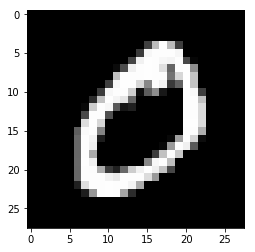

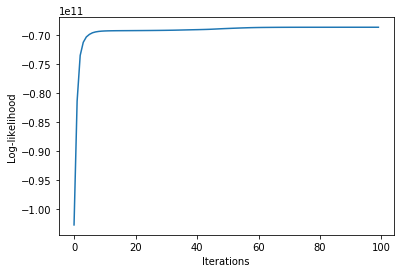

In [17]:
plt.imshow(images[1,:,:],interpolation='None',cmap='Greys_r')
sz = images.shape
xs = numpy.reshape(images,(sz[0],sz[1]*sz[2])).transpose()

means,alphas,qs = mog(xs,20,100)

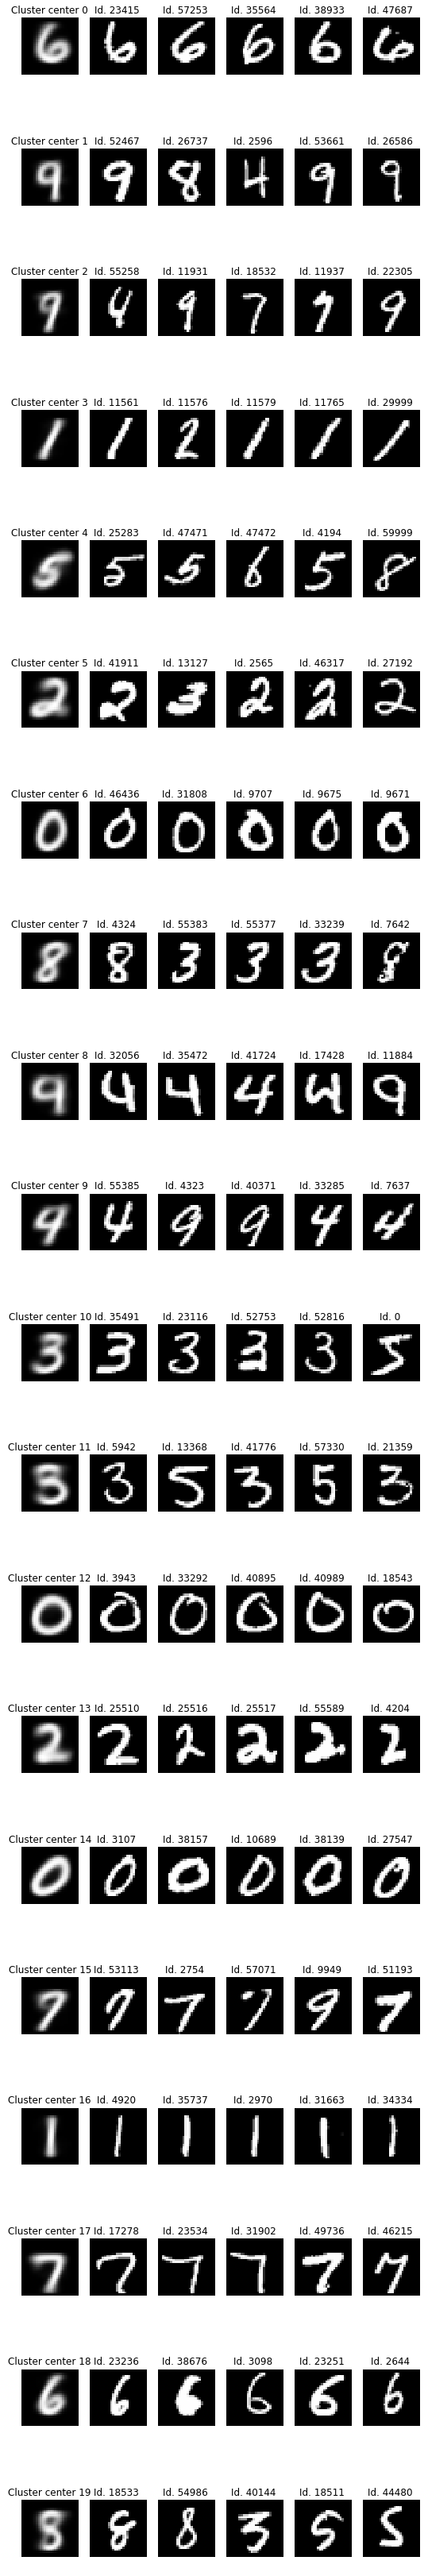

In [18]:
def show_digit(x):
    im = numpy.reshape(x,[28,28])
    plt.imshow(im,interpolation='None',cmap='Greys_r')
    plt.axis('off')

plt.figure(figsize=(9,60))
for k in range(20):    
    plt.subplot(20,6,k*6+1)
    show_digit(means[:,k])        
    plt.title('Cluster center {}'.format(k))
    lst = numpy.argsort(qs[k,:])[-5:]
    for j in range(5):
        plt.subplot(20,6,k*6+j+2)        
        show_digit(xs[:,lst[j]])
        plt.title('Id. {} '.format(lst[j]))


    

# Video of parameter changes during learning

# Covered

* Mixture models
* EM algorithm
* K-means